## Perspective PS3

### 1. Some income data, lognormal distribution, and GMM

#### a). plot the histogram 

In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import pandas as pd

<IPython.core.display.Javascript object>


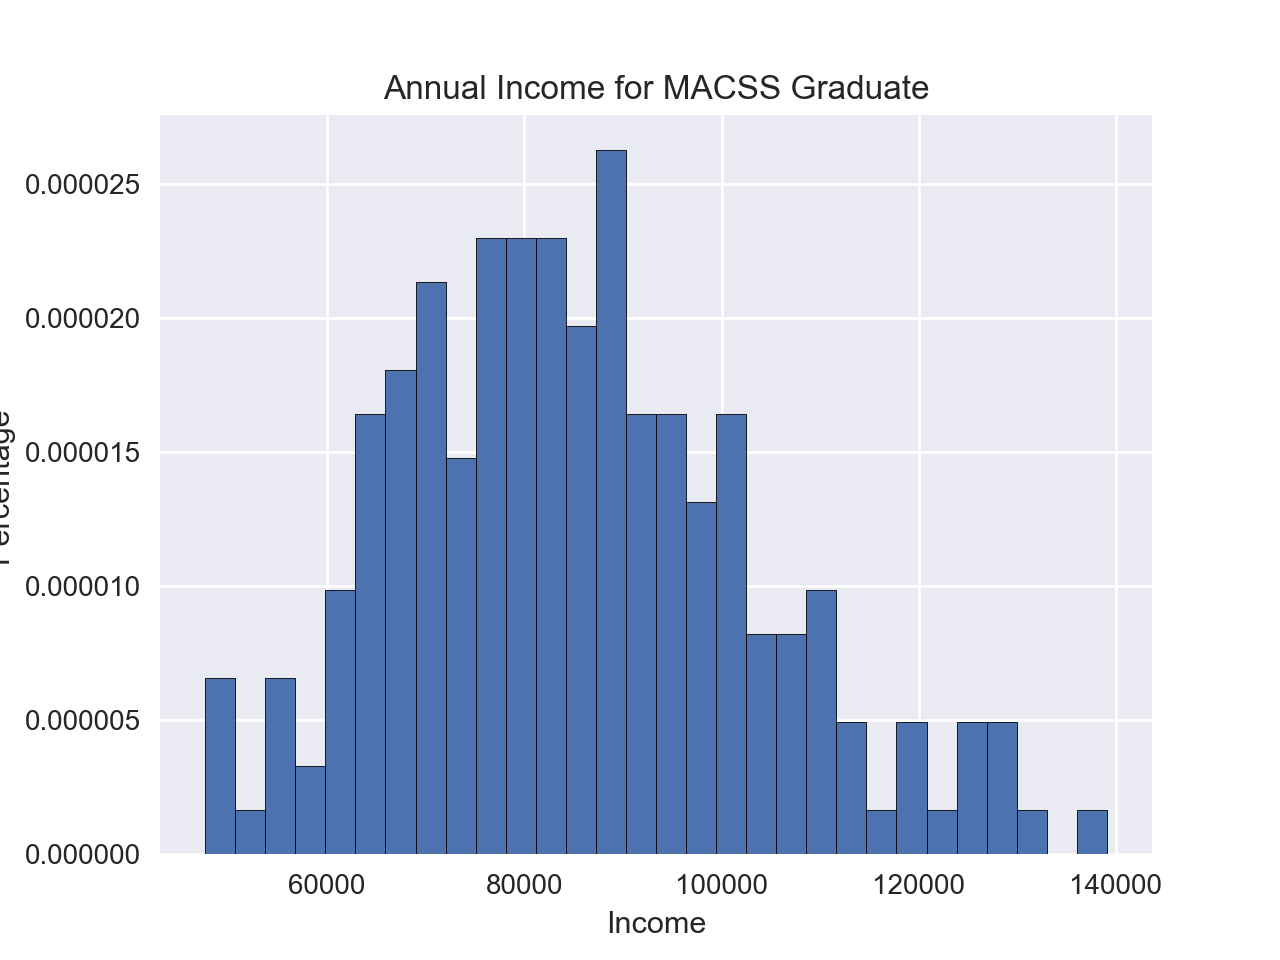

Text(0,0.5,'Percentage')

In [2]:
income = np.array(pd.read_csv('incomes.txt', header=None))
sns.set(style="darkgrid")
xvals = np.linspace(0.00001, 150000, 10000)

%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual Income for MACSS Graduate')
plt.xlabel('Income')
plt.ylabel('Percentage')

#### b). estimate the parameter using GMM

In [3]:
# define the pdf function for lognormal distribution
def lognormal_pdf(xvals, mu, sigma):
    
    fx = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma ** 2)))
    
    return fx

In [4]:
def data_moments(xvals):
    
    mean_data = xvals.mean()
    var_data = xvals.var()
    std_data = np.sqrt(var_data)
    
    return mean_data, std_data


def model_moments(mu, sigma):
    
    mean_model = np.exp(mu + sigma**2/2)
    var_model = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [5]:
mu_init, sig_init = data_moments(np.log(income))
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM, sig_GMM = results.x
print('mu_GMM=', mu_GMM, ' sig_GMM=', sig_GMM)

mu_GMM= 11.3318848383  sig_GMM= 0.208696331742


<IPython.core.display.Javascript object>


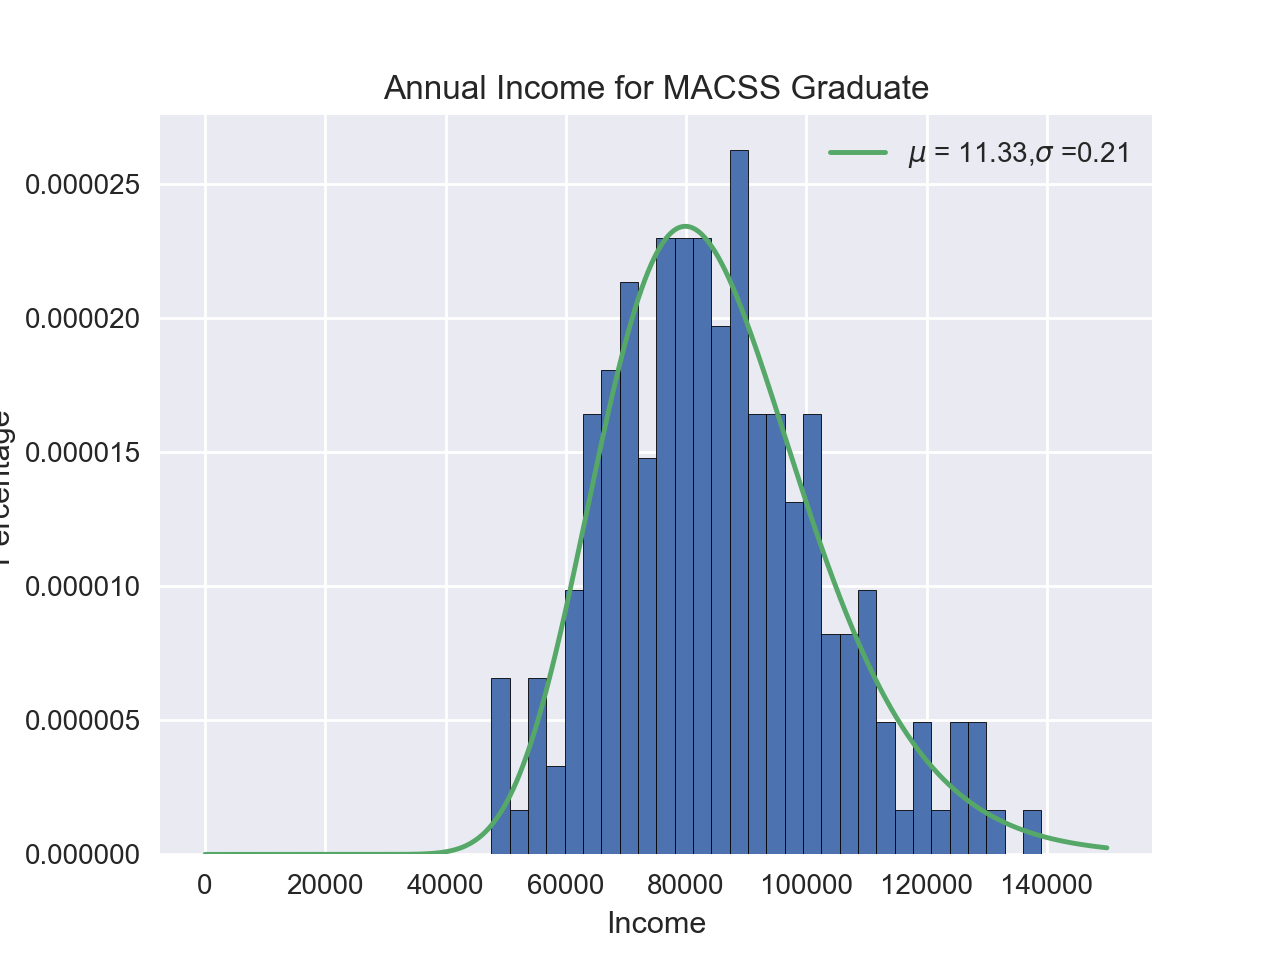

In [6]:
# plot the graph
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM, sig_GMM), 
         label = '$\mu$ = '+ str(mu_GMM.round(2)) + ',$\sigma$ ='+ str(sig_GMM.round(2)))
plt.title('Annual Income for MACSS Graduate')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.legend()

In [7]:
print("value of GMM criterion function at the estimated parameter values: ", results.fun[0][0])
print()
print("data mean: ", data_moments(income)[0])
print("model mean (GMM): ", model_moments(mu_GMM, sig_GMM)[0])
print()
print("data standard deviation: ", data_moments(income)[1])
print("model standard deviation (GMM): ", model_moments(mu_GMM, sig_GMM)[1])
print()
print("differences of moments between data and model estimates: ")
print([data_moments(income)[0] - model_moments(mu_GMM, sig_GMM)[0], data_moments(income)[1] - model_moments(mu_GMM, sig_GMM)[1]])

value of GMM criterion function at the estimated parameter values:  2.07487051183e-11

data mean:  85276.8236063
model mean (GMM):  85277.1583751

data standard deviation:  17992.542128
model standard deviation (GMM):  17992.5836974

differences of moments between data and model estimates: 
[-0.33476888820587192, -0.041569392058590893]


It can be seen that the differences of moments generated from data and GMM estimation are small. The data mean and stadard deviation are slightly smaller than the ones from GMM estimation.

#### c). Perform a two-step GMM estimation 

In [7]:
results

      fun: array([[  2.07487051e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921238e-05,   2.54906503e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])

In [8]:
err = err_vec(income, results.x[0], results.x[1], False)
VCV_opt = np.dot(err, err.T) / income.shape[0]
print(VCV_opt)
W_hat_opt = lin.pinv(VCV_opt)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat_opt)

[[  7.70545261e-14   4.53487399e-14]
 [  4.53487399e-14   2.66889995e-14]]
[[  7.15939209e+12   4.21350213e+12]
 [  4.21350213e+12   2.47976364e+12]]


In [9]:
params_init = np.array([mu_GMM, sig_GMM])
W_hat = W_hat_opt
gmm_args_opt = (income, W_hat)
res_opt = opt.minimize(criterion, params_init, args=(gmm_args_opt),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_opt, sig_GMM_opt = res_opt.x
print('mu_GMM_opt=', mu_GMM_opt, ' sig_GMM_opt=', sig_GMM_opt)
print("value of GMM criterion function at the estimated parameter values: ", res_opt.fun[0][0])

mu_GMM_opt= 11.3318829172  sig_GMM_opt= 0.208695636449
value of GMM criterion function at the estimated parameter values:  1.82898801355e-06


<IPython.core.display.Javascript object>


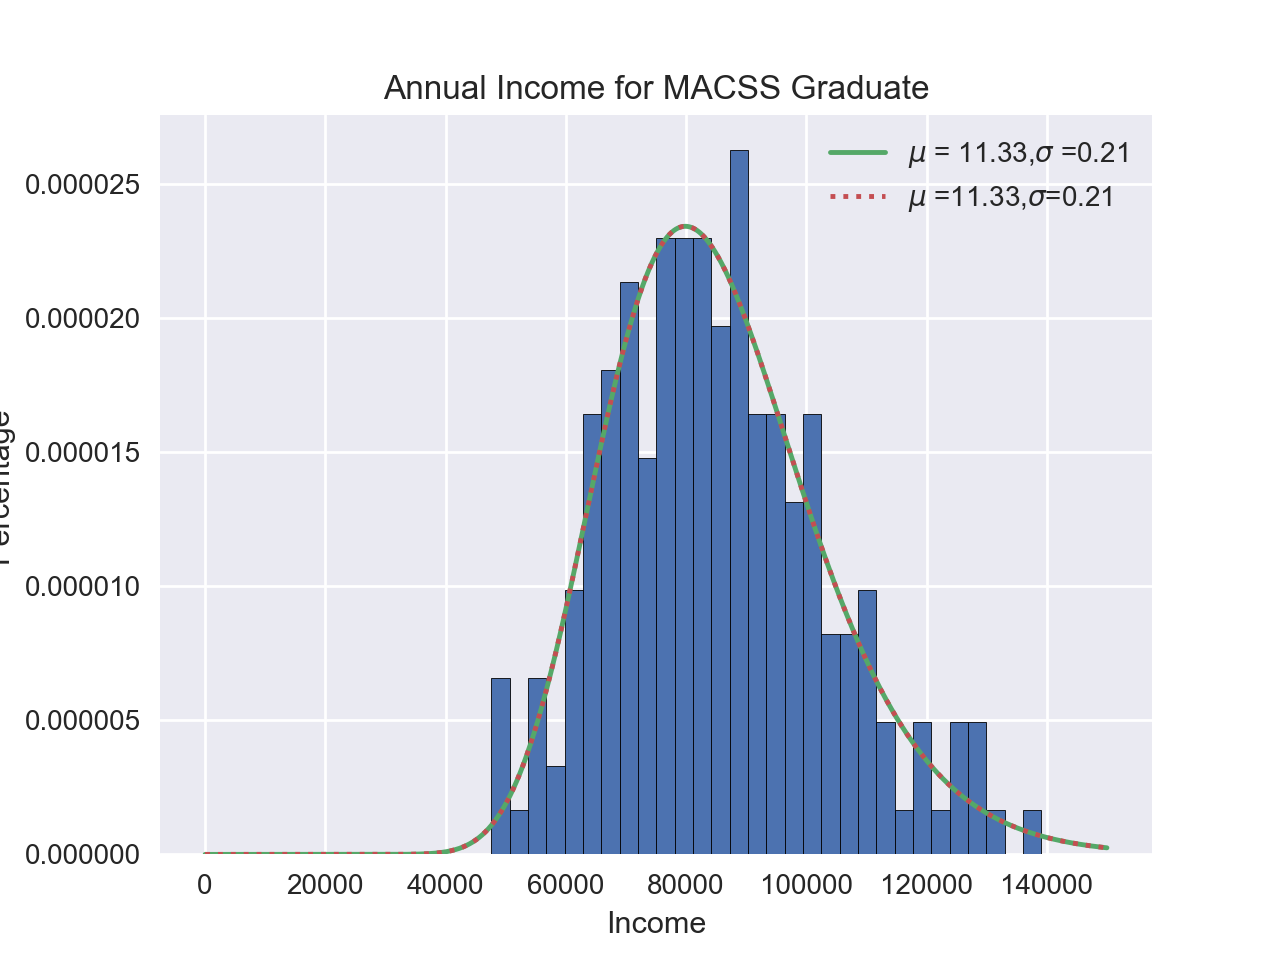

In [10]:
# plot the graph
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM, sig_GMM), 
         label = '$\mu$ = '+ str(mu_GMM.round(2)) + ',$\sigma$ ='+ str(sig_GMM.round(2)))
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM_opt, sig_GMM_opt), 
         label ='$\mu$ =' + str(mu_GMM_opt.round(2))+',$\sigma$='+ str(sig_GMM_opt.round(2)), linestyle=':')
plt.title('Annual Income for MACSS Graduate')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.legend()

In [12]:
print("data mean: ", data_moments(income)[0])
print("model mean (optimal GMM): ", model_moments(mu_GMM_opt, sig_GMM_opt)[0])
print()
print("data standard deviation: ", data_moments(income)[1])
print("model standard deviation (optimal GMM): ", model_moments(mu_GMM_opt, sig_GMM_opt)[1])
print()
print("differences of moments between data and model estimates: ")
print([data_moments(income)[0] - model_moments(mu_GMM_opt, sig_GMM_opt)[0], 
       data_moments(income)[1] - model_moments(mu_GMM_opt, sig_GMM_opt)[1]])

data mean:  85276.8236063
model mean (optimal GMM):  85276.9821799

data standard deviation:  17992.542128
model standard deviation (optimal GMM):  17992.4852632

differences of moments between data and model estimates: 
[-0.15857365919509903, 0.056864800597395515]


Once again, the differences of data and model moments are quite small. However, the data mean is slightly smaller than the model mean under GMM using the optimal weighting matrix, while the data standard deviation is slightly bigger for the model standard deviation. 

#### d). estiamte model using different moments

In [11]:
def data_moments(xvals):
    
    dta_less = len([x for x in xvals if x < 75000])/len(income)
    dta_between = len([x for x in xvals if 75000 <= x <= 100000])/len(income)
    dta_more = len([x for x in xvals if x > 100000])/len(income)
    
    return dta_less, dta_between, dta_more

def lognorm_cdf(x, mu, sigma):
    
    return intgr.quad(lambda x: lognormal_pdf(x, mu, sigma), 1e-10, x)[0]

def model_moments(mu, sigma):
    
    model_less = lognorm_cdf(75000, mu, sigma)
    model_between = lognorm_cdf(100000, mu, sigma) - model_less
    model_more = 1 - model_between - model_less
    
    return model_less, model_between, model_more

def err_vec(xvals, mu, sigma, simple):

    dta_less, dta_between, dta_more = data_moments(xvals)
    moms_data = np.array([[dta_less], [dta_between], [dta_more]])
    model_less, model_between, model_more = model_moments(mu, sigma)
    moms_model = np.array([[model_less], [model_between], [model_more]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion2(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [12]:
mu_init = mu_GMM
sig_init = sig_GMM
params_init = np.array([mu_init, sig_init])
W_hat2 = np.eye(3)
gmm_args = (income, W_hat2)
res2 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = res2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
print("value of GMM criterion function at the estimated parameter values: ", res2.fun[0][0])

mu_GMM2= 11.3356813261  sig_GMM2= 0.210598566911
value of GMM criterion function at the estimated parameter values:  7.21408610526e-14


<IPython.core.display.Javascript object>


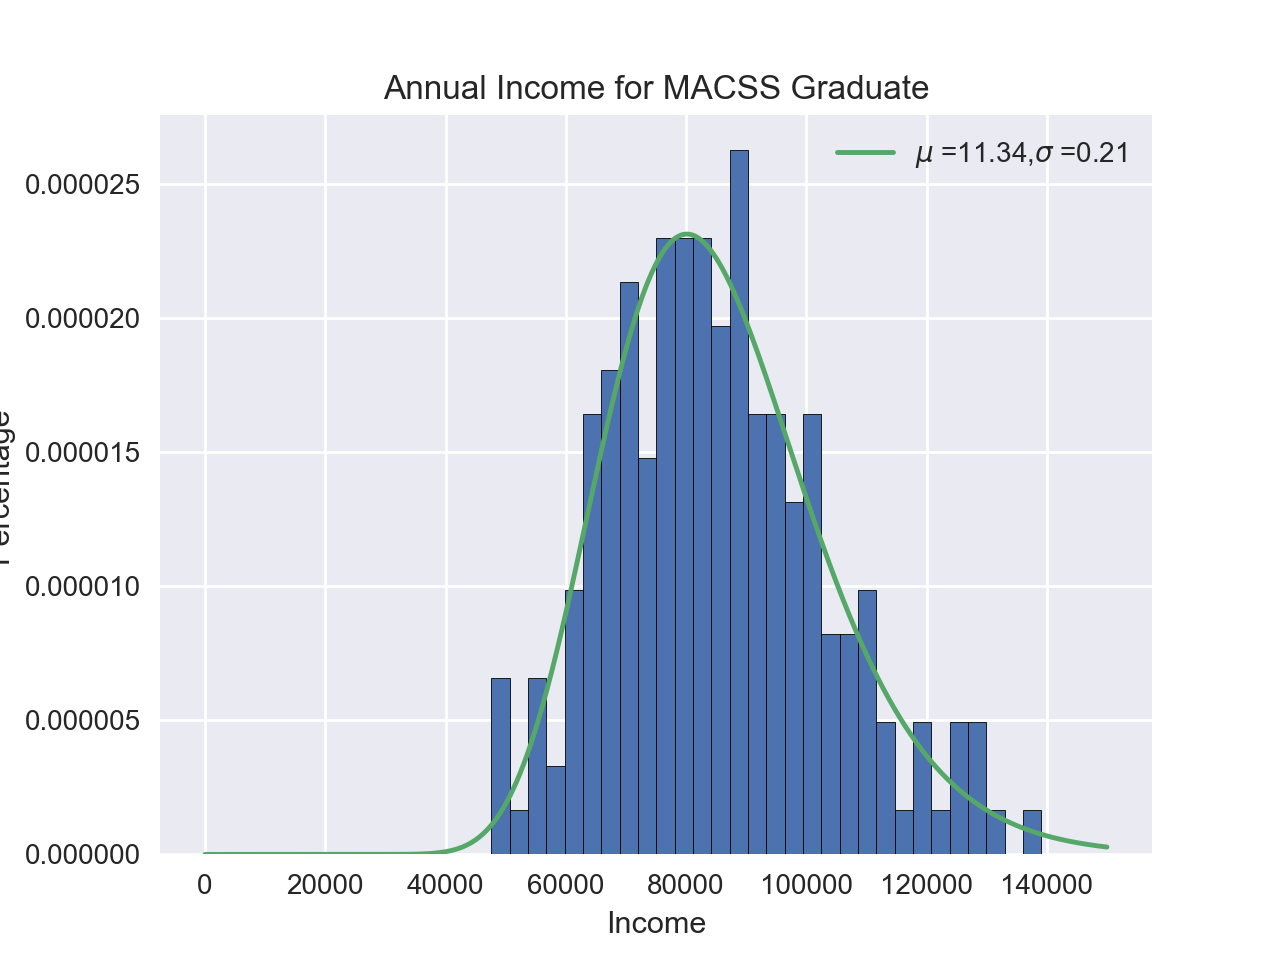

In [13]:
# plot the graph
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM2, sig_GMM2), 
         label = '$\mu$ ='+ str(mu_GMM2.round(2))+',$\sigma$ ='+str(sig_GMM2.round(2)))
plt.title('Annual Income for MACSS Graduate')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.legend()

In [16]:
print("data moment(under 75000): ", data_moments(income)[0])
print("model mean(under 75000) : ", model_moments(mu_GMM2, sig_GMM2)[0])
print()
print("data moment(between 75000 and 100000): ", data_moments(income)[1])
print("model moment(between 75000 and 100000): ", model_moments(mu_GMM2, sig_GMM2)[1])
print()
print("data moment(above 100000): ", data_moments(income)[2])
print("model moment(above 100000): ", model_moments(mu_GMM2, sig_GMM2)[2])
print()
print("differences of moments between data and model estimates: ")
print([data_moments(income)[0] - model_moments(mu_GMM2, sig_GMM2)[0], 
       data_moments(income)[1] - model_moments(mu_GMM2, sig_GMM2)[1],
     data_moments(income)[2] - model_moments(mu_GMM2, sig_GMM2)[2]])

data moment(under 75000):  0.3
model mean(under 75000) :  0.30000010377399133

data moment(between 75000 and 100000):  0.5
model moment(between 75000 and 100000):  0.49999978079997565

data moment(above 100000):  0.2
model moment(above 100000):  0.20000011542603302

differences of moments between data and model estimates: 
[-1.0377399134453569e-07, 2.1920002435393826e-07, -1.1542603300940257e-07]


Model moments using GMM are very close to the data moments.

#### e). estimate with optimal weighting matrix

In [14]:
err2 = err_vec(income, mu_GMM2, sig_GMM2, False)
VCV2_opt = np.dot(err2, err2.T) / income.shape[0]
W_hat2_opt = lin.pinv(VCV2_opt)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_opt)

[[  5.75359885e+13  -7.29193698e+13   9.59944417e+13]
 [ -7.29193698e+13   9.24158014e+13  -1.21660449e+14]
 [  9.59944417e+13  -1.21660449e+14   1.60159460e+14]]


In [15]:
params_init = np.array([mu_GMM2, sig_GMM2])
gmm_args = (income, W_hat2_opt)
res2_opt = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_opt, sig_GMM2_opt = res2_opt.x
print('mu_GMM2_opt=', mu_GMM2_opt, ' sig_GMM2_opt=', sig_GMM2_opt)
print("value of GMM criterion function at the estimated parameter values: ", res2_opt.fun[0][0])

mu_GMM2_opt= 11.3356777204  sig_GMM2_opt= 0.210598566911
value of GMM criterion function at the estimated parameter values:  6.12630897096e-06


<IPython.core.display.Javascript object>


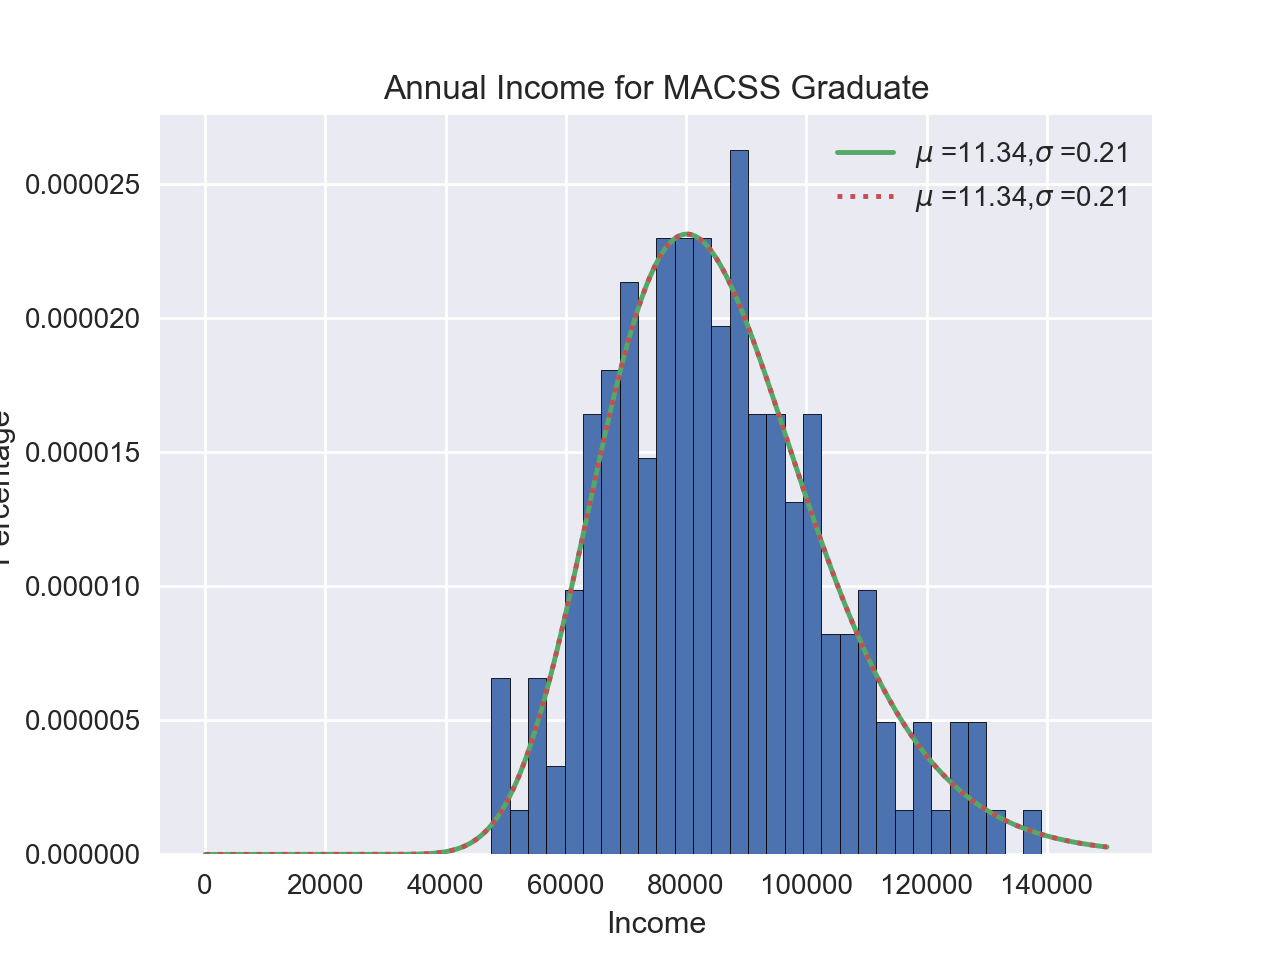

In [16]:
# plot the graph
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM2, sig_GMM2), 
         label = '$\mu$ ='+ str(mu_GMM2.round(2))+',$\sigma$ ='+str(sig_GMM2.round(2)))
plt.plot(xvals, lognormal_pdf(xvals, mu_GMM2_opt, sig_GMM2_opt), 
         label = '$\mu$ ='+ str(mu_GMM2_opt.round(2))+',$\sigma$ ='+str(sig_GMM2_opt.round(2)), linestyle =":")
plt.title('Annual Income for MACSS Graduate')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.legend()

In [20]:
print("data moment(under 75000): ", data_moments(income)[0])
print("model mean(under 75000) : ", model_moments(mu_GMM2_opt, sig_GMM2_opt)[0])
print()
print("data moment(between 75000 and 100000): ", data_moments(income)[1])
print("model moment(between 75000 and 100000): ", model_moments(mu_GMM2_opt, sig_GMM2_opt)[1])
print()
print("data moment(above 100000): ", data_moments(income)[2])
print("model moment(above 100000): ", model_moments(mu_GMM2_opt, sig_GMM2_opt)[2])
print()
print("differences of moments between data and model estimates: ")
print([data_moments(income)[0] - model_moments(mu_GMM2_opt, sig_GMM2_opt)[0], 
       data_moments(income)[1] - model_moments(mu_GMM2_opt, sig_GMM2_opt)[1],
     data_moments(income)[2] - model_moments(mu_GMM2_opt, sig_GMM2_opt)[2]])

data moment(under 75000):  0.3
model mean(under 75000) :  0.30000605682320786

data moment(between 75000 and 100000):  0.5
model moment(between 75000 and 100000):  0.49999862108802534

data moment(above 100000):  0.2
model moment(above 100000):  0.19999532208876675

differences of moments between data and model estimates: 
[-6.056823207867268e-06, 1.3789119746587808e-06, 4.677911233263998e-06]


Once again, the model moments are extremely similar to the data moments. 

#### f). compare and constrast

In [21]:
print(results.fun[0][0],",", res_opt.fun[0][0],",", res2.fun[0][0],",", res2_opt.fun[0][0])
print("estimated mean from the four methods")
print(results.x[0], res_opt.x[0], res2.x[0], res2_opt.x[0])
print("estimated standard deviation from the four methods")
print(results.x[1], res_opt.x[1], res2.x[1], res2_opt.x[1])

2.07487051183e-11 , 1.82898801355e-06 , 7.21408610526e-14 , 6.12630897096e-06
estimated mean from the four methods
11.3318848383 11.3318829172 11.3356813261 11.3356777204
estimated standard deviation from the four methods
0.208696331742 0.208695636449 0.210598566911 0.210598566911


We can see that the parameters estimated from the four methods are quite similar from each other. And all of these methods give every small value for the criterion function. I think using the mean and standard deviation as the moment functions are more appropriate than using the three proportions, since these two indices better summarize the properties of the income distribution (centrality and spread) than the selected three percentiles.  

From part d) we can find that the variances of the estimates are small, therefore, I think using the optimal weighting matrix does not provide huge improvement for the variance. Hence, I think the solution from part b) is the best (in terms of computation simplicity).

### 2. Linear Regression and GMM

#### a). estimate the parameters

In [22]:
sick = pd.read_csv('sick.txt', sep=",", header=0)
sick.head()
n = sick.shape[0]

In [23]:
def data_moments(dta):
    
    return dta.iloc[:,0]

def model_moments(beta, dta):

    X = np.concatenate((np.ones((n,1)), dta.values[:,1:]), axis = 1)
    yhat = X @ beta
    
    return yhat

def err_vec(beta, dta):
    
    yvals = data_moments(dta)
    yhat = model_moments(beta, dta) 
    err_vec = yhat - yvals
    
    return err_vec

def criterion_2(params, *args):
    
    beta = params
    dta, W = args
    err = err_vec(beta, dta)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [24]:
params_init = np.array([0,0,0,0])
W_hat_2 = np.eye(200)
gmm_args = (sick, W_hat_2)
res_2 = opt.minimize(criterion_2, params_init, args=(gmm_args), method='L-BFGS-B')
b0, b1, b2, b3 = res_2.x
print('b0：', b0, '，b1：', b1, '，b2：', b2, '，b3：', b3)
print("value of GMM criterion function at the estimated parameter values: ", res_2.fun)

b0： 0.251645509687 ，b1： 0.0129335435156 ，b2： 0.400500379768 ，b3： -0.00999176786264
value of GMM criterion function at the estimated parameter values:  0.00182128981357
